In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import tensorflow as tf

import numpy as np
import sys

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [0]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [0]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [0]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [0]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [0]:
def add_noise(x, mode='crop', elementwise=False):
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            for i in range(x.shape[0]):
                img_part = np.random.randint(2)
                if img_part == 0:
                    x[i, :, :14, :14] = torch.flip(x[i, :, 14:, 14:], (1, 2))
                else:
                    x[i, :, :14, 14:] = torch.flip(x[i, :, 14:, :14], (1, 2))
        elif mode == 'gaussian':
            for i in range(x.shape[0]):
                noise = np.random.normal(0.0, 1.0, x.shape[2:])
                x[i, :, :, :] += noise
        else:
            assert "unknown mode:" + mode
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
        elif mode == 'gaussian':
            noise = np.random.normal(0.0, 1.0, x.shape[2:])
            x[:, :, :, :] += noise
        elif mode == 'mirror':
            img_part = np.random.randint(2)
            if img_part == 0:
                x[:, :, :14, :14] = torch.flip(x[:, :, 14:, 14:], (2, 3))
            else:
                x[:, :, :14, 14:] = torch.flip(x[:, :, 14:, :14], (2, 3))
        else:
            assert "unknown mode:" + mode
        
    return x


In [0]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data, mode='gaussian')
        for model in models.values():
            model.optim.zero_grad()
            output = model(noized)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [0]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data, mode='gaussian')
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [135]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 16: 0.980572 32: 1.000113 64: 1.022841
Train Epoch: 1 [30000/60000] 16: 0.828312 32: 0.660353 64: 0.444109
Train Epoch: 1 [60000/60000] 16: 0.605919 32: 0.403542 64: 0.286345
Test set:
16: loss: 0.6135
32: loss: 0.4116
64: loss: 0.2973

Train Epoch: 2 [00000/60000] 16: 0.610829 32: 0.409706 64: 0.295101
Train Epoch: 2 [30000/60000] 16: 0.461743 32: 0.330654 64: 0.287081
Train Epoch: 2 [60000/60000] 16: 0.370536 32: 0.295180 64: 0.270522
Test set:
16: loss: 0.3720
32: loss: 0.2969
64: loss: 0.2724

Train Epoch: 3 [00000/60000] 16: 0.372491 32: 0.297264 64: 0.273674
Train Epoch: 3 [30000/60000] 16: 0.327970 32: 0.283277 64: 0.264736
Train Epoch: 3 [60000/60000] 16: 0.307952 32: 0.278931 64: 0.258457
Test set:
16: loss: 0.3093
32: loss: 0.2802
64: loss: 0.2593

Train Epoch: 4 [00000/60000] 16: 0.298757 32: 0.269257 64: 0.249304
Train Epoch: 4 [30000/60000] 16: 0.291451 32: 0.270276 64: 0.245378
Train Epoch: 4 [60000/60000] 16: 0.289336 32: 0.271286 64: 0.24197

In [0]:
data, _ = next(iter(test_loader))
noized_gaussian = add_noise(data, mode='gaussian', elementwise=True)
noized_mirror = add_noise(data, mode='mirror', elementwise=True)
output_gaussian = models['64'](noized_gaussian[:50])
output_mirror = models['64'](noized_mirror[:50])
to_plot_gaussian = output_gaussian.view(-1, 1, 28, 28).data.numpy()
to_plot_mirror = output_mirror.view(-1, 1, 28, 28).data.numpy()

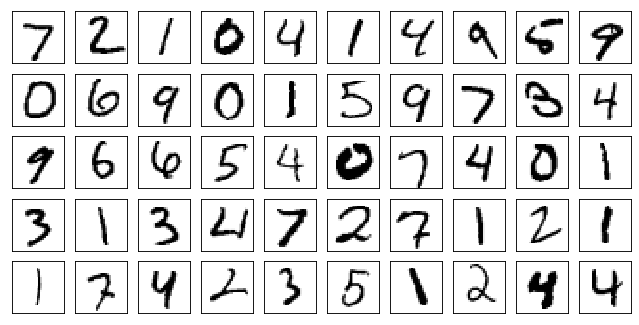

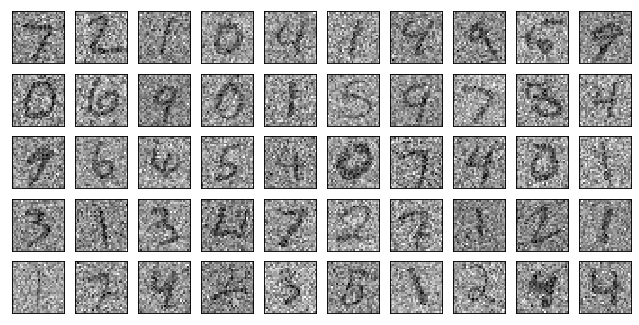

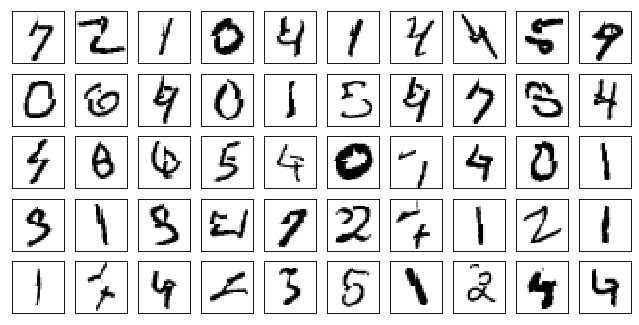

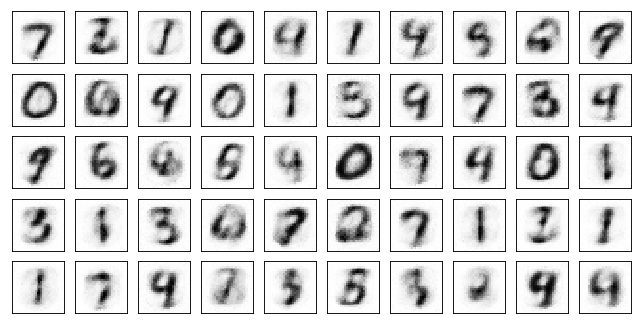

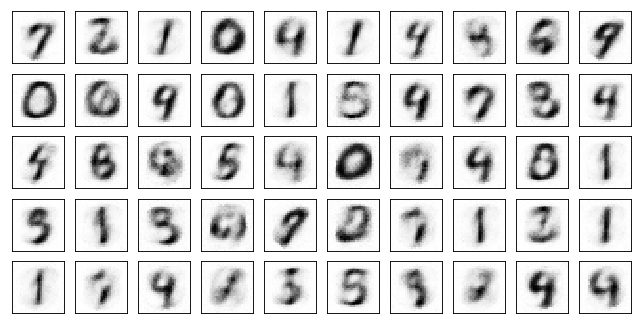

In [137]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized_gaussian[:50], (5, 10))
plot_mnist(noized_mirror[:50], (5, 10))
plot_mnist(to_plot_gaussian, (5, 10))
plot_mnist(to_plot_mirror, (5, 10))

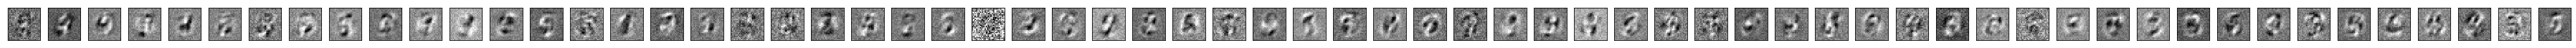

In [138]:
# Weight maps
weights = models['64'].E.fc1.weight.data
weights = weights.reshape((64, 1, 28, 28))
plot_mnist(weights, (64, 784))